In [ ]:
# generate random data

import torch
from pathlib import Path

device = torch.device("cuda:0")

n_nodes = 50
n_points = 100
n_trials = 5

p_save = Path("data/toy_example")
p_save.mkdir(parents=True, exist_ok=True)

for i_trial in range(n_trials):
    # if data already exists, skip
    if (p_save / f"n{n_nodes}_p{n_points}_{i_trial}.pt").exists():
        continue
    
    # generate random data
    alpha_matrix = torch.randn(n_nodes, n_nodes, device=device)
    alpha_matrix = torch.tril(alpha_matrix, diagonal=-1)
    alpha_matrix = alpha_matrix + alpha_matrix.t()

    random_points = torch.rand(n_points, n_nodes, device=device)
    
    torch.save(
        {
            "alpha_matrix": alpha_matrix.cpu(),
            "random_points": random_points.cpu(),
        },
        f"data/toy_example/n{n_nodes}_p{n_points}_{i_trial}.pt"
    )

In [ ]:
# functions

import torch
from pathlib import Path

device = torch.device("cuda:0")

def obj_func(X, alpha_matrix):
    # X: (n_nodes,)
    # obj = \sum_{i,j} alpha_ij * X_i * X_j
    XX = torch.outer(X, X)  # XX: (n_nodes, n_nodes); XX[i, j] = X_i * X_j
    return torch.sum(alpha_matrix * XX) / 2

def sampling(X, alpha_matrix, n_samples=10, device=device):
    # X: (n_nodes,)
    # multi-sampling from X
    best_obj = float('inf')
    best_sample = None
    for i in range(n_samples):
        # sample discrete value seeing X as bernoulli distribution
        X_sample = torch.bernoulli(X, device=device)
        obj = obj_func(X_sample, alpha_matrix)
        if obj < best_obj:
            best_obj = obj
            best_sample = X_sample
    return best_obj, best_sample

def seq_rounding(X, alpha_matrix):
    # X: (n_nodes,)
    # fixed sequence rounding
    X_clone = X.clone()
    for i in range(n_nodes):
        delta_obj_i = torch.sum(alpha_matrix[i] * X_clone)  # delta_obj_i: scalar
        delta_obj_i0 = -X_clone[i] * delta_obj_i
        delta_obj_i1 = (1-X_clone[i]) * delta_obj_i
        if delta_obj_i0 < delta_obj_i1:
            X_clone[i] = 0
        else:
            X_clone[i] = 1        
    return obj_func(X_clone, alpha_matrix), X_clone


def soft_seq_rounding(X, alpha_matrix, temp=1.0, device=device):
    # X: (n_nodes,)
    # soft version of fixed sequence rounding
    X_clone = X.clone()
    for i in range(n_nodes):
        delta_obj_i = torch.sum(alpha_matrix[i] * X_clone)
        delta_obj_i0 = -X_clone[i] * delta_obj_i
        delta_obj_i1 = (1-X_clone[i]) * delta_obj_i
        delta_obj = torch.tensor([delta_obj_i0, delta_obj_i1], device=device)
        min_idx = torch.softmax(-delta_obj / temp, dim=0)
        step0, step1 = min_idx[0], min_idx[1]
        step_diff = step1 - step0
        sign_right = (step_diff > 0).float()
        X_i_new = X_clone[i] + step_diff * (X_clone[i] + sign_right * (1 - 2 * X_clone[i]))
        X_clone[i] = X_i_new
    return X_clone


def greedy_rounding(X, alpha_matrix):
    # X: (n_nodes,)
    # greedy rounding
    X_clone = X.clone()
    while True:
        # delta_obj_z[i] = \sum_j alpha_{ij} * (z - X_i) * X_j = (z - X_i) * \sum_j alpha_{ij} * X_j        
        # delta_obj[i] = \sum_j alpha_{ij} * X_j
        delta_obj = torch.sum(alpha_matrix * X_clone, dim=-1)  # delta_obj: (n_nodes,)
        delta_obj_0 = -X_clone * delta_obj  # (n_nodes,)
        delta_obj_1 = (1-X_clone) * delta_obj  # (n_nodes,)
        delta_obj = torch.stack([delta_obj_0, delta_obj_1], dim=-1)  # (n_nodes, 2)
        # find the minmum 2d index of delta_obj
        min_idx = torch.argmin(delta_obj)
        best_i, best_val = min_idx // 2, min_idx % 2
        if X_clone[best_i] == best_val:  # no change
            break
        X_clone[best_i] = best_val
    return obj_func(X_clone, alpha_matrix), X_clone


def soft_greedy_rounding(X, alpha_matrix, temp=1.0, n_iter=100):
    # X: (n_nodes,)
    # soft version of greedy rounding    
    X_clone = X.clone()
    for _ in range(n_iter):
        delta_obj = torch.sum(alpha_matrix * X_clone, dim=-1)  # delta_obj: (n_nodes,)
        delta_obj_0 = -X_clone * delta_obj  # (n_nodes,)
        delta_obj_1 = (1-X_clone) * delta_obj  # (n_nodes,)
        delta_obj = torch.stack([delta_obj_0, delta_obj_1], dim=-1)  # (n_nodes, 2)
        
        delta_obj_flatten = delta_obj.flatten() # (n_nodes * 2, )
        min_idx = torch.softmax(-delta_obj_flatten / temp, dim=0).reshape_as(delta_obj)  # (n_nodes, 2)        
        step0, step1 = min_idx[:, 0], min_idx[:, 1]
        step_diff = step1 - step0
        sign_right = (step_diff > 0).float()        
        X_new = X_clone + step_diff * (X_clone + sign_right * (1 - 2 * X_clone))
        X_clone = X_new.clamp(0.0, 1.0)
    return X_clone


In [ ]:
# bad cases

import torch
from pathlib import Path
from itertools import combinations

device = torch.device("cuda:0")

n_nodes = 50
n_points = 100
n_trials = 5

p_save = Path("data/toy_example")
p_save.mkdir(parents=True, exist_ok=True)

for i_trial in range(n_trials):    
    # load data
    data = torch.load(f"data/toy_example/n{n_nodes}_p{n_points}_{i_trial}.pt")
    alpha_matrix = data["alpha_matrix"].to(device)
    random_points = data["random_points"].to(device)
    
    # compute objective
    obj_func_values = []
    for i in range(n_points):
        obj_func_values.append(obj_func(random_points[i], alpha_matrix))
    obj_func_values = torch.stack(obj_func_values)
    
    # compute objective after seq_rounding
    seq_rounding_values = []
    for i in range(n_points):
        seq_rounding_values.append(seq_rounding(random_points[i], alpha_matrix)[0])
    seq_rounding_values = torch.stack(seq_rounding_values)
    
    # compute objective after greedy_rounding
    greedy_rounding_values = []
    for i in range(n_points):
        greedy_rounding_values.append(greedy_rounding(random_points[i], alpha_matrix)[0])
    greedy_rounding_values = torch.stack(greedy_rounding_values)
    
    # bad case = a pair where the relative relations w.r.t. objective and after rounding are different
    cnt_bad_case_seq = 0
    cnt_bad_case_greedy = 0
    
    for i, j in combinations(range(n_points), 2):
        if (obj_func_values[i] - obj_func_values[j]) * (seq_rounding_values[i] - seq_rounding_values[j]) < 0:
            cnt_bad_case_seq += 1
        if (obj_func_values[i] - obj_func_values[j]) * (greedy_rounding_values[i] - greedy_rounding_values[j]) < 0:
            cnt_bad_case_greedy += 1
    print(f"Trial {i_trial}: bad case seq: {cnt_bad_case_seq}, bad case greedy: {cnt_bad_case_greedy}")

/tmp/ipykernel_22095/1502644942.py:74: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  best_i, best_val = min_idx // 2, min_idx % 2


Trial 0: bad case seq: 1968, bad case greedy: 1958
Trial 1: bad case seq: 1826, bad case greedy: 2252
Trial 2: bad case seq: 1957, bad case greedy: 2299
Trial 3: bad case seq: 2094, bad case greedy: 1974
Trial 4: bad case seq: 1549, bad case greedy: 1321


In [ ]:
# softmax

import torch
from pathlib import Path
from itertools import combinations

device = torch.device("cuda:0")

temp_list = [10.0, 1.0, 1e-1, 1e-2, 1e-3]

n_nodes = 50
n_points = 100
n_trials = 5

p_save = Path("data/toy_example")
p_save.mkdir(parents=True, exist_ok=True)

for temp in temp_list:
    print()
    for i_trial in range(n_trials):    
        # load data
        data = torch.load(f"data/toy_example/n{n_nodes}_p{n_points}_{i_trial}.pt")
        alpha_matrix = data["alpha_matrix"].to(device)
        random_points = data["random_points"].to(device)
        
        # compute objective
        obj_func_values_soft_seq = []
        obj_func_values_soft_greedy = []
        for i in range(n_points):
            # apply soft seq rounding
            soft_seq_rounding_values = soft_seq_rounding(random_points[i], alpha_matrix, temp)            
            obj_func_values_soft_seq.append(obj_func(soft_seq_rounding_values, alpha_matrix))
            # apply soft greedy rounding
            soft_greedy_rounding_values = soft_greedy_rounding(random_points[i], alpha_matrix, temp, n_iter=200)
            obj_func_values_soft_greedy.append(obj_func(soft_greedy_rounding_values, alpha_matrix))
        obj_func_values_soft_seq = torch.stack(obj_func_values_soft_seq)
        obj_func_values_soft_greedy = torch.stack(obj_func_values_soft_greedy)
        
        # compute objective after seq_rounding
        seq_rounding_values = []
        for i in range(n_points):
            seq_rounding_values.append(seq_rounding(random_points[i], alpha_matrix)[0])
        seq_rounding_values = torch.stack(seq_rounding_values)
        
        # compute objective after greedy_rounding
        greedy_rounding_values = []
        for i in range(n_points):
            greedy_rounding_values.append(greedy_rounding(random_points[i], alpha_matrix)[0])
        greedy_rounding_values = torch.stack(greedy_rounding_values)
        
        # bad case = a pair where the relative relations w.r.t. objective and after rounding are different
        cnt_bad_case_seq = 0
        cnt_bad_case_greedy = 0
        
        for i, j in combinations(range(n_points), 2):
            # if (obj_func_values[i] - obj_func_values[j]) * (seq_rounding_values[i] - seq_rounding_values[j]) < 0:
            #     cnt_bad_case_seq += 1
            # if (obj_func_values[i] - obj_func_values[j]) * (greedy_rounding_values[i] - greedy_rounding_values[j]) < 0:
            #     cnt_bad_case_greedy += 1
            if (obj_func_values_soft_seq[i] - obj_func_values_soft_seq[j]) * (seq_rounding_values[i] - seq_rounding_values[j]) < 0:
                cnt_bad_case_seq += 1
            if (obj_func_values_soft_greedy[i] - obj_func_values_soft_greedy[j]) * (greedy_rounding_values[i] - greedy_rounding_values[j]) < 0:
                cnt_bad_case_greedy += 1
        print(f"Trial {i_trial}; Temp {temp}: bad case seq: {cnt_bad_case_seq}, bad case greedy: {cnt_bad_case_greedy}")

/tmp/ipykernel_22095/1684515850.py:74: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  best_i, best_val = min_idx // 2, min_idx % 2


Trial 0; Temp 10.0: bad case seq: 1861, bad case greedy: 1908
Trial 1; Temp 10.0: bad case seq: 1869, bad case greedy: 2177
Trial 2; Temp 10.0: bad case seq: 1679, bad case greedy: 2407
Trial 3; Temp 10.0: bad case seq: 2000, bad case greedy: 1958
Trial 4; Temp 10.0: bad case seq: 1538, bad case greedy: 1229

Trial 0; Temp 1.0: bad case seq: 1252, bad case greedy: 1669
Trial 1; Temp 1.0: bad case seq: 1430, bad case greedy: 1499
Trial 2; Temp 1.0: bad case seq: 1436, bad case greedy: 1762
Trial 3; Temp 1.0: bad case seq: 1220, bad case greedy: 1778
Trial 4; Temp 1.0: bad case seq: 1335, bad case greedy: 676

Trial 0; Temp 0.1: bad case seq: 598, bad case greedy: 1165
Trial 1; Temp 0.1: bad case seq: 548, bad case greedy: 811
Trial 2; Temp 0.1: bad case seq: 776, bad case greedy: 1027
Trial 3; Temp 0.1: bad case seq: 368, bad case greedy: 1377
Trial 4; Temp 0.1: bad case seq: 587, bad case greedy: 469

Trial 0; Temp 0.01: bad case seq: 44, bad case greedy: 997
Trial 1; Temp 0.01: bad ca

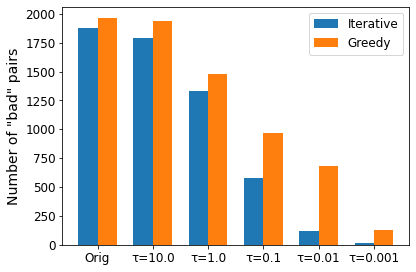

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Increase all font sizes for PDF readability
plt.rcParams.update({
    'font.size':        14,   # base font size
    'axes.titlesize':   16,
    'axes.labelsize':   14,
    'xtick.labelsize':  12,
    'ytick.labelsize':  12,
    'legend.fontsize':  12,
})

# Data (average values)
labels    = ['Orig', 'τ=10.0', 'τ=1.0', 'τ=0.1', 'τ=0.01', 'τ=0.001']
iterative = [1878.8, 1789.4, 1334.6, 575.4, 120.8, 18.4]
greedy    = [1960.8, 1935.8, 1476.8, 969.8,  679.2, 128.6]

n     = len(labels)
x     = np.arange(n)      # positions for each τ
width = 0.35              # bar width

fig, ax = plt.subplots()

# Plot one bar for iterative (shifted left), one for greedy (shifted right)
ax.bar(x - width/2, iterative, width, label='Iterative')
ax.bar(x + width/2, greedy,    width, label='Greedy')

# Use the τ labels on the x-axis
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.set_ylabel('Number of "bad" pairs')
# ax.set_title('Iterative vs. Greedy Rounding Performance')
ax.legend()

plt.tight_layout()

# Save as PDF for LaTeX inclusion
plt.savefig('bad_pairs_toy.pdf', bbox_inches='tight')
# plt.show()
